In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
from sklearn.preprocessing import minmax_scale
import pickle as pkl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:

def retrieve_dataset(df, start, end):
    output_df = df.loc[start:end]
    output_df.columns = df.loc[start-1]
    output_df.columns.name = None
    output_df = output_df.set_index('Cycle Nr.', drop=True)
    output_df = output_df.drop(['Time [s]', 'Temp. [°C]'], axis=1)
    return output_df
    # return od600, gfp, rfp

def layoutToDict(layoutName,dataDf ):
    layoutDict = {}
    originalLayoutDf = pd.read_csv(layoutName, sep=',', header=None)
    layoutNp = originalLayoutDf.to_numpy()
    layoutNp = layoutNp.reshape(1,96)[0]
    index_list= list(dataDf.to_dict().keys())
    for count, col in enumerate(index_list):
        layoutDict[col] = layoutNp[count]
    return layoutDict

def reject_outliers(data, m=2):
    data = np.array(data)
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def maxgrowth_data(output_df):
    od600 = retrieve_dataset(output_df, 96, 203) #start should be where title of dataset (e.g. 0d600)
    
    gfp = retrieve_dataset(output_df, 207, 314) #start should be where title of dataset (e.g. 0d600)
    rfp = retrieve_dataset(output_df, 318, 425) #start should be where title of dataset (e.g. 0d600)
    maxValues = od600.max()
    for column in od600.columns:
        od600[column] = pd.to_numeric(od600[column])

        # maxValues, maxValueIndex
    od600max = pd.Series(maxValues, index=od600.columns)
    maxValueIndex = od600.idxmax()
    gfpMax = {}
    rfpMax = {}
    for index, column in zip(maxValueIndex, gfp.columns):
        gfpMax[column] = gfp.loc[index, column]
        rfpMax[column] = rfp.loc[index, column]


    gfpMax = pd.Series(gfpMax)
    rfpMax = pd.Series(rfpMax)

    maxValueIndex = od600.idxmax()
    return od600max, gfpMax, rfpMax, maxValueIndex

def IndexConcDict(ATC_layoutName,morphogen_layoutName,referenceDf):

    #get names of layouts
    ATC_layoutDict = layoutToDict(ATC_layoutName,referenceDf)
    morphogen_layoutDict = layoutToDict(morphogen_layoutName,referenceDf)
    # print(morphogen_layoutDict)
    #storage arrays
    ATC_layout_index = []
    highATC_morphogen_layoutDict = {}

    #loop over df of fixed molecule and select desired concentration
    for k,v in ATC_layoutDict.items():
        if v == '-0.5': #dose responses will be fixed for this concentration (e.g High ATC)
            ATC_layout_index.append(k)
    #loop over variable molecule #e.g OC14 or HSL
    for k,v in morphogen_layoutDict.items():
        if k in ATC_layout_index:
            if v == 'ZERO':
                highATC_morphogen_layoutDict[k] = -5
            else:
                highATC_morphogen_layoutDict[k] = v
    

    highATC_morphogen_layoutDict = dict(sorted(highATC_morphogen_layoutDict.items(), key=lambda item: float(item[1])))
    return highATC_morphogen_layoutDict

def substractEmptyCells(od600,gfp,rfp ,layoutDict):
    #find empty cells 
    emptyod600 = []
    emptygfp = []
    emptyrfp = []
    for key, value in layoutDict.items():
        if value == 'empty':
            emptyod600.append(od600[key])
            emptygfp.append(gfp[key])
            emptyrfp.append(rfp[key])


    #substract mean of empty cells from all cells
    #make sure to remove outliers
    od600 = od600 - np.amin(emptyod600) + 1e-08
    gfp = gfp - np.amin(emptygfp)
    rfp = rfp - np.amin(emptyrfp)
    return od600, gfp, rfp


def curveTransfer(gfpReplicates, rfpReplicates):
    gfpVmax, rfpVmax = np.mean(gfpReplicates[10e0]), np.mean(rfpReplicates[10e-3])

    gfpTransfered = pd.DataFrame(columns=gfpReplicates.columns)
    rfpTransfered = pd.DataFrame(columns=rfpReplicates.columns)
    for index, row in gfpReplicates.iterrows():
        arr = pd.Series(minmax_scale(row, feature_range=(1,gfpVmax)), index=gfpReplicates.columns)
        gfpTransfered = gfpTransfered.append(arr, ignore_index=True)

    for index, row in rfpReplicates.iterrows():
        arr = pd.Series(minmax_scale(row, feature_range=(1,rfpVmax)), index=rfpReplicates.columns)
        rfpTransfered = rfpTransfered.append(arr, ignore_index=True)

    return gfpTransfered, rfpTransfered

    #substract mean of empty cells from all cells
    #make sure to remove outliers
    od600 = od600 - np.mean(reject_outliers(emptyod600))
    gfp = gfp - np.mean(reject_outliers(emptygfp))
    rfp = rfp - np.mean(reject_outliers(emptyrfp))
    return od600, gfp, rfp


def plotDoseResponsevsData(inducer, rfpExp_list, gfpExp_list, semRed, semGreen,pad=0.01, inducerName='OC14'):
    fig,ax = plt.subplots()

    ax.plot(inducer,rfpExp_list,label='RFP', c='red')
    ax.scatter(inducer,rfpExp_list, c='red')
    ax.errorbar(inducer,rfpExp_list,yerr=semRed,c='red',fmt='o')
    ax.legend(loc='center left') #upper right
    ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$')
    ax.set_xscale('log')


    ax2=ax.twinx()
    ax2.plot(inducer,gfpExp_list,label='GFP', c='green')
    ax2.scatter(inducer,gfpExp_list, c='green')
    ax2.errorbar(inducer,gfpExp_list,yerr=semGreen,c='green',fmt='o')
    ax2.legend(loc='center right') #upper left
    ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$')
    ax.set_xscale('log')

    ax.set_xlabel(f'{inducerName} concentration (µM)')

    plt.show()


Labelling some past liquid culture experiments for Martina
==========================================================

Hi Martiiii hope this is good for you!

Here are a few subcircuits that I tested.

### IMPORTANT:
All of the numbers are to be taken as 10**(csvValue). Absolute zero is a string ("ZERO")

Each plate has two inducers: 1. ATC, 2. either HSL or pC.

Two experiments in Subcircuit A also have a column of IPTG - so these have another csv for IPTG setup.

lmk if you have any questions!!

Subcircuit #1:
-------------
<img src="subcircuitFigures/Subcircuit1.png" width="500" height="200">


### Plasmid Contents:
pCOLA-nodeA-pC-tacI  : nodeA
pCDF-nodeBdel-$\Delta$ lacI  : nodeB without diffuser enzyme
pET-nodeC   : node C
pCC1-rpaR-Q168R   : control cassete

### Experiments:
E20201120A: Data missing (it's on the old TECAN most likely - lmk if you need it)  
E20201123B  
E20201124A  
E20201125C  
E20201126A  




In [5]:
import os

# vvvvvvv CHANGE ME vvvvvvv
current_path = ''
# ^^^^^^^ CHANGE ME ^^^^^^^


################
# SUBCIRCUIT A #
################

# data csvs
E20201123Bcsv = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201124_143339.xlsx')#
E20201124Acsv = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201125_132310.xlsx')#
E20201125Ccsv = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201126_130251.xlsx')#
E20201126Acsv = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201127_113952.xlsx')
data_list = [E20201123Bcsv, E20201124Acsv, E20201125Ccsv, E20201126Acsv]


# ATC layout csvs
E20201123B_ATClayout = os.path.join(current_path, 'ATClayout/E20201123B_ATClayout.csv')
E20201124A_ATClayout = os.path.join(current_path, 'ATClayout/E20201124A_ATClayout.csv')#
E20201125C_ATClayout = os.path.join(current_path, 'ATClayout/E20201125C_ATClayout.csv')#
E20201126A_ATClayout = os.path.join(current_path, 'ATClayout/E20201126A_ATClayout.csv')#
ATC_layout_list = [E20201123B_ATClayout, E20201124A_ATClayout, E20201125C_ATClayout, E20201126A_ATClayout]

# HSL layout csvs
E20201123B_HSLlayout = os.path.join(current_path, 'HSLlayout/E20201123B_HSLlayout.csv')
E20201124A_HSLlayout = os.path.join(current_path, 'HSLlayout/E20201124A_HSLlayout.csv')#
E20201125C_HSLlayout = os.path.join(current_path, 'HSLlayout/E20201125C_HSLlayout.csv')#
E20201126A_HSLlayout = os.path.join(current_path, 'HSLlayout/E20201126A_HSLlayout.csv')#
HSL_layout_list = [E20201123B_HSLlayout, E20201124A_HSLlayout, E20201125C_HSLlayout, E20201126A_HSLlayout]

data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201124_143339.xlsx
data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201125_132310.xlsx
data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201126_130251.xlsx
data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201127_113952.xlsx


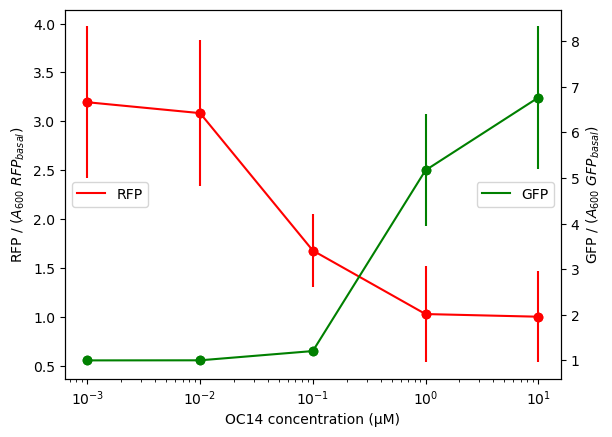

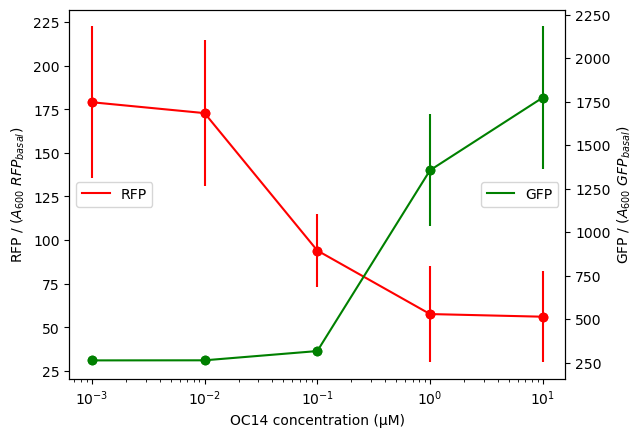

0.001     1.000000
0.010     1.001792
0.100     1.204678
1.000     5.168783
10.000    6.761773
dtype: float64

In [10]:
OC14_list = np.logspace(-3,1,5)
gfpReplicates = pd.DataFrame()
rfpReplicates = pd.DataFrame()



for count, dataName in enumerate(data_list):
    print(dataName)
    #import data
    output_df = pd.read_excel(dataName)
    #take fluorescence for highest OD600
    od600Max, gfpMax, rfpMax, maxValueIndex = maxgrowth_data(output_df)
    #   # select only relevant index columns
    ATC_layoutName = ATC_layout_list[count]
    HSL_layoutName = HSL_layout_list[count]

    # print(ATC_layoutName, pC_layoutName)
    highATC_HSL_layoutDict = IndexConcDict(ATC_layoutName,HSL_layoutName,od600Max)

    # print(highATC_HSL_layoutDict)
    od600Max = od600Max[highATC_HSL_layoutDict.keys()]
    gfpMax = gfpMax[highATC_HSL_layoutDict.keys()]
    rfpMax = rfpMax[highATC_HSL_layoutDict.keys()]
    
    # subs_od600, subs_gfp, subs_rfp   = od600Max, gfpMax, rfpMax
    
    #relativise to od600
    relGfp = gfpMax/od600Max
    relRfp = rfpMax/od600Max

#     #Average intraexperimental replicates
    intraexperiment_mean_gfp = pd.Series(np.mean(np.stack((relGfp[:10:2], relGfp[1:11:2])), axis=0))
    intraexperiment_mean_rfp = pd.Series(np.mean(np.stack((relRfp[:10:2], relRfp[1:11:2])), axis=0))
    
    #add to dataframe
    gfpReplicates = gfpReplicates.append(intraexperiment_mean_gfp, ignore_index=True)
    rfpReplicates = rfpReplicates.append(intraexperiment_mean_rfp, ignore_index=True)


#define columns as OC14 concentrations
gfpReplicates.columns = OC14_list
rfpReplicates.columns = OC14_list

#average interexperimental replicates 
meanGfp = gfpReplicates.mean(axis=0)
meanGfp_basal = meanGfp/np.amin(meanGfp)
stdGfp = gfpReplicates.std(axis=0)
stdGfp_basal = stdGfp/np.amin(meanGfp)

meanRfp = rfpReplicates.mean(axis=0)
meanRfp_basal = meanRfp/np.amin(meanRfp)
stdRfp = rfpReplicates.std(axis=0)
stdRfp_basal = stdRfp/np.amin(meanRfp)

plotDoseResponsevsData(OC14_list, meanRfp_basal, meanGfp_basal, stdRfp_basal ,stdGfp_basal, inducerName='OC14') 
plt.show()
plotDoseResponsevsData(OC14_list, meanRfp, meanGfp, stdRfp ,stdGfp, inducerName='OC14') 
meanGfp_basal


In [11]:
dataDict = {}
dataDict['OC14'] = OC14_list
dataDict['mean_gfp'] = meanGfp_basal
dataDict['std_gfp'] = stdGfp_basal
dataDict['mean_rfp'] = meanRfp_basal
dataDict['std_rfp'] = stdRfp_basal
pkl.dump(dataDict, open('curatedData/nonTransferred_subcircuit1_circuit14_doseResponseOC14_-0.5ATC.pkl', 'wb'))


In [6]:
# match curves : find average Vmax of both curves
gfpTransfered, rfpTransfered = curveTransfer(gfpReplicates, rfpReplicates)
meanGfp = gfpTransfered.mean(axis=0)
stdGfp = gfpTransfered.std(axis=0)
meanRfp = rfpTransfered.mean(axis=0)
stdRfp = rfpTransfered.std(axis=0)

rfpTransfered

dataDict = {}
dataDict['OC14'] = OC14_list
dataDict['mean_gfp'] = meanGfp
dataDict['std_gfp'] = stdGfp
dataDict['mean_rfp'] = meanRfp
dataDict['std_rfp'] = stdRfp
pkl.dump(dataDict, open('curatedData/subcircuit1_circuit14_doseResponseOC14_maxATC.pkl', 'wb'))
gfpTransfered
gfpTransfered

,0.001,0.010,0.100,1.000,10.000
0,1.899686,1.0,39.258317,1198.890916,1660.825776
1,13.724425,1.0,71.525719,1236.092256,1660.825776
2,1.088802,1.0,60.902303,1329.608531,1660.825776
3,1.705514,1.0,43.600525,1335.266684,1660.825776


Subcircuit #4
-------------
<img src="subcircuitFigures/Subcircuit4.png" width="500" height="200">


### Plasmid Contents:
p15a-hpv0t  
pCDF-B-pC-$\Delta$ cI   
pET-nodeC  
pCC1-rpaR-Q168R  


### Experiments:
E20201203A  
E20201204A  
E20201207A  
E20201208A  
E20201209A  
E20201216A  

In [137]:
################
# SUBCIRCUIT B #
################

E20201203A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201204_111319.xlsx')
E20201204A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201205_114446.xlsx')
E20201207A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201208_120526.xlsx')
E20201208A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201209_123927.xlsx')
E20201209A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201210_110325.xlsx')
E20201210A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201211_103415.xlsx')
E20201216A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201217_100522.xlsx')
# data_list = [E20201203A, E20201204A, E20201207A, E20201208A, E20201209A, E20201210A, E20201216A]
data_list = [ E20201207A, E20201208A, E20201209A, E20201210A, E20201216A]

# ATC layout csvs
E20201203A_ATClayout = os.path.join(current_path, 'ATClayout/E20201203A_ATClayout.csv')
E20201204A_ATClayout = os.path.join(current_path, 'ATClayout/E20201204A_ATClayout.csv')
E20201207A_ATClayout = os.path.join(current_path, 'ATClayout/E20201207A_ATClayout.csv')
E20201208A_ATClayout = os.path.join(current_path, 'ATClayout/E20201208A_ATClayout.csv')
E20201209A_ATClayout = os.path.join(current_path, 'ATClayout/E20201209A_ATClayout.csv')
E20201210A_ATClayout = os.path.join(current_path, 'ATClayout/E20201210A_ATClayout.csv')
# E20201216A_ATClayout = os.path.join(current_path, 'ATClayout/E20201207A_ATClayout.csv')
E20201216A_ATClayout = os.path.join(current_path, 'ATClayout/E20201216A_ATClayout.csv')
# ATC_layout_list =[E20201203A_ATClayout, E20201204A_ATClayout, E20201207A_ATClayout, E20201208A_ATClayout, E20201209A_ATClayout, E20201210A_ATClayout, E20201216A_ATClayout]
ATC_layout_list =[ E20201207A_ATClayout, E20201208A_ATClayout, E20201209A_ATClayout, E20201210A_ATClayout, E20201216A_ATClayout] #leave out two first ones as they do not contain data for 0.5 ATC

# pC layout csvs
E20201203A_pClayout = os.path.join(current_path, 'pClayout/E20201203A_pClayout.csv')
E20201204A_pClayout = os.path.join(current_path, 'pClayout/E20201204A_pClayout.csv')
E20201207A_pClayout = os.path.join(current_path, 'pClayout/E20201207A_pClayout.csv')
E20201208A_pClayout = os.path.join(current_path, 'pClayout/E20201208A_pClayout.csv')
E20201209A_pClayout = os.path.join(current_path, 'pClayout/E20201209A_pClayout.csv')
E20201210A_pClayout = os.path.join(current_path, 'pClayout/E20201210A_pClayout.csv')
# E20201216A_pClayout = os.path.join(current_path, 'pClayout/E20201207A_pClayout.csv')
E20201216A_pClayout = os.path.join(current_path, 'pClayout/E20201216A_pClayout.csv')
# pC_layout_list = [E20201203A_pClayout, E20201204A_pClayout, E20201207A_pClayout, E20201208A_pClayout, E20201209A_pClayout, E20201210A_pClayout, E20201216A_pClayout]
pC_layout_list = [ E20201207A_pClayout, E20201208A_pClayout, E20201209A_pClayout, E20201210A_pClayout, E20201216A_pClayout]

data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201208_120526.xlsx
{'B9': '-3.33', 'C9': '-3.33', 'D9': '-3', 'E9': '-3', 'F9': '-2.67', 'G9': '-2.67'}
{'B9': '-3.33', 'C9': '-3.33', 'D9': '-3', 'E9': '-3', 'F9': '-2.67', 'G9': '-2.67'}
data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201209_123927.xlsx
{'B8': '-3.33', 'C8': '-3.33', 'D8': '-3', 'E8': '-3', 'F8': '-2.67', 'G8': '-2.67'}
{'B8': '-3.33', 'C8': '-3.33', 'D8': '-3', 'E8': '-3', 'F8': '-2.67', 'G8': '-2.67'}
data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201210_110325.xlsx
{'B7': '-3.33', 'C7': '-3.33', 'D7': '-3', 'E7': '-3', 'F7': '-2.67', 'G7': '-2.67'}
{'B7': '-3.33', 'C7': '-3.33', 'D7': '-3', 'E7': '-3', 'F7': '-2.67', 'G7': '-2.67'}
data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201211_103415.xlsx
{'B8': '-3.33', 'C8': '-3.33', 'D8': '-3', 'E8': '-3', 'F8': '-2.67', 'G8': '-2.67'}
{'B8': '-3.33', 'C8': '-3.33', 'D8': '-3', 'E8': '-3', 'F8': '-2.67', 'G8': '-2.67'}
data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201217_100522.xlsx
{'B8': '-3

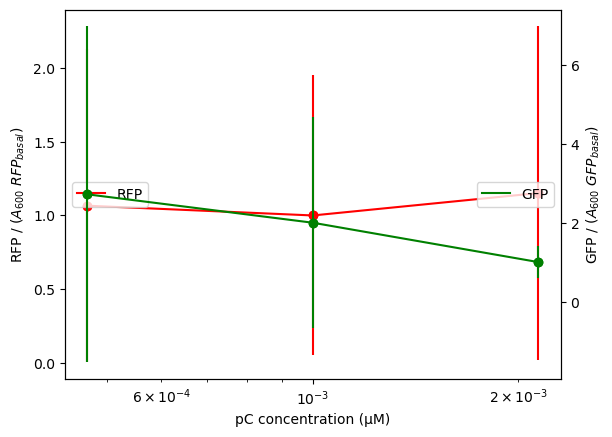

In [145]:
pC_list = [10**-2.67, 10**-3, 10**-3.33]
gfpReplicates = pd.DataFrame()
rfpReplicates = pd.DataFrame()

def IndexConcDict(ATC_layoutName,morphogen_layoutName,referenceDf):
    #get names of layouts
    ATC_layoutDict = layoutToDict(ATC_layoutName,referenceDf)
    morphogen_layoutDict = layoutToDict(morphogen_layoutName,referenceDf)
    #storage arrays
    ATC_layout_index = []
    highATC_morphogen_layoutDict = {}

    #loop over df of fixed molecule and select desired concentration
    for k,v in ATC_layoutDict.items():
        if v == '-0.5': #dose responses will be fixed for this concentration (e.g High ATC)
            ATC_layout_index.append(k)
    #loop over variable molecule #e.g OC14 or HSL
    for k,v in morphogen_layoutDict.items():
        if k in ATC_layout_index:
            if v == 'ZERO':
                highATC_morphogen_layoutDict[k] = -5
                print('hihihi')
            else:
                highATC_morphogen_layoutDict[k] = v
    

    highATC_morphogen_layoutDict = dict(sorted(highATC_morphogen_layoutDict.items(), key=lambda item: float(item[1])))
    print(highATC_morphogen_layoutDict)
    return highATC_morphogen_layoutDict


for count, dataName in enumerate(data_list):
    print(dataName)
    #import data
    output_df = pd.read_excel(dataName)
    #take fluorescence for highest OD600
    od600Max, gfpMax, rfpMax, maxValueIndex = maxgrowth_data(output_df)
    #   # select only relevant index columns
    ATC_layoutName = ATC_layout_list[count]
    pC_layoutName = pC_layout_list[count]

    # print(ATC_layoutName, pC_layoutName)
    highATC_pC_layoutDict = IndexConcDict(ATC_layoutName,pC_layoutName,od600Max)

    print(highATC_pC_layoutDict)
    od600Max = od600Max[highATC_pC_layoutDict.keys()]
    gfpMax = gfpMax[highATC_pC_layoutDict.keys()]
    rfpMax = rfpMax[highATC_pC_layoutDict.keys()]
    
    # subs_od600, subs_gfp, subs_rfp   = od600Max, gfpMax, rfpMax
    
    #relativise to od600
    relGfp = gfpMax/od600Max
    relRfp = rfpMax/od600Max

    # print(relGfp, relRfp)
#     #Average intraexperimental replicates
    intraexperiment_mean_gfp = pd.Series(np.mean(np.stack((relGfp[:8:2], relGfp[1:9:2])), axis=0))
    intraexperiment_mean_rfp = pd.Series(np.mean(np.stack((relRfp[:8:2], relRfp[1:9:2])), axis=0))
    
    #add to dataframe
    gfpReplicates = gfpReplicates.append(intraexperiment_mean_gfp, ignore_index=True)
    rfpReplicates = rfpReplicates.append(intraexperiment_mean_rfp, ignore_index=True)


#define columns as OC14 concentrations
gfpReplicates.columns = pC_list
rfpReplicates.columns = pC_list
print(gfpReplicates)

#average interexperimental replicates 
meanGfp = gfpReplicates.mean(axis=0)
meanGfp_basal = meanGfp/np.amin(meanGfp)
stdGfp = gfpReplicates.std(axis=0)
stdGfp_basal = stdGfp/np.amin(meanGfp)

meanRfp = rfpReplicates.mean(axis=0)
meanRfp_basal = meanRfp/np.amin(meanRfp)
stdRfp = rfpReplicates.std(axis=0)
stdRfp_basal = stdRfp/np.amin(meanRfp)
print(meanGfp, meanRfp)
pC_list = [10**-2.67, 10**-3, 10**-3.33 ]
plotDoseResponsevsData(pC_list, meanRfp_basal, meanGfp_basal, stdRfp_basal ,stdGfp_basal, inducerName='pC') 
# plotDoseResponsevsData(pC_list, meanRfp, meanGfp, stdRfp ,stdGfp, inducerName='pC') 



Subcircuit C:

<img src="subcircuitFigures/Subcircuit3.png" width="500" height="200">


nodeA intact; pCDF Bdele delta cI; node C intact
E20201211A: NEEDS IPTG SETUP AS WELL  
E20201213A: NEEDS IPTG SETUP AS WELL  


In [9]:
import os

# vvvvvvv CHANGE ME vvvvvvv
current_path = ''
# ^^^^^^^ CHANGE ME ^^^^^^^

# IPTG layout csvs
E20201211Acsv = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201212_122750.xlsx')
E20201213Acsv = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201214_120458.xlsx')
data_list= [E20201211Acsv, E20201213Acsv]
# data_list= [E20201211Acsv, E20201211Acsv]
# data_list= [E20201213Acsv, E20201213Acsv]

E20201211A_ATClayout = os.path.join(current_path, 'ATClayout/E20201211A_ATClayout.csv')
E20201213A_ATClayout = os.path.join(current_path, 'ATClayout/E20201213A_ATClayout.csv')
ATC_layout_list = [E20201211A_ATClayout, E20201213A_ATClayout]
# ATC_layout_list = [E20201211A_ATClayout, E20201211A_ATClayout]
# ATC_layout_list =  [E20201213A_ATClayout, E20201213A_ATClayout]

E20201211A_IPTGlayout = os.path.join(current_path, 'IPTGlayout/E20201211A_IPTGlayout.csv')
E20201213A_IPTGlayout = os.path.join(current_path, 'IPTGlayout/E20201213A_IPTGlayout.csv')
# IPTG_layout_list = [E20201211A_IPTGlayout, E20201213Acsv]
# IPTG_layout_list = [E20201211A_IPTGlayout, E20201211A_IPTGlayout]
IPTG_layout_list = [E20201211A_IPTGlayout, E20201213A_IPTGlayout]

E20201211A_HSLlayout = os.path.join(current_path, 'HSLlayout/E20201211A_HSLlayout.csv')
E20201213A_HSLlayout = os.path.join(current_path, 'HSLlayout/E20201213A_HSLlayout.csv')
# ATC_layout_list = [E20201211A_ATClayout, E20201213A_ATClayout]
# HSL_layout_list = [E20201211A_HSLlayout, E20201211A_HSLlayout]
HSL_layout_list = [E20201211A_HSLlayout, E20201213A_HSLlayout]


data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201212_122750.xlsx
{'B5': -5, 'B10': -5, 'C5': '-1.5', 'C10': '-1.5', 'D5': '-1', 'D10': '-1', 'E5': '-0.5', 'E10': '-0.5', 'F5': '0', 'F10': '0', 'G5': '1', 'G10': '1'}
B5      318.381208
B10     309.278351
C5      323.393835
C10     309.155767
D5      363.506261
D10     361.487904
E5      514.941873
E10     650.788326
F5     1227.597932
F10    1828.224247
G5     2920.527942
G10     3266.21183
dtype: object B5      126.64497
B10    212.371134
C5     141.169692
C10    181.856333
D5     158.855098
D10    209.760873
E5     212.538335
E10    271.720899
F5     165.049231
F10    158.105496
G5     423.336142
G10    405.378552
dtype: object
data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201214_120458.xlsx
{'B5': -5, 'B9': -5, 'C5': '-1.5', 'C9': '-1.5', 'D5': '-1', 'D9': '-1', 'E5': '-0.5', 'E9': '-0.5', 'F5': '0', 'F9': '0', 'G5': '1', 'G9': '1'}
B5     326.524741
B9     321.149377
C5     320.641283
C9     312.323745
D5     331.178161
D9     323.895028


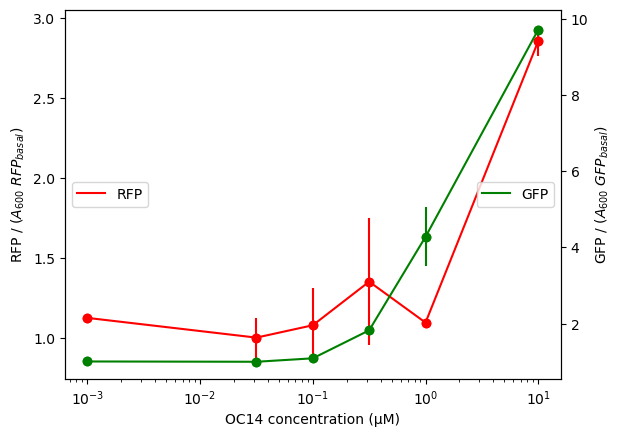

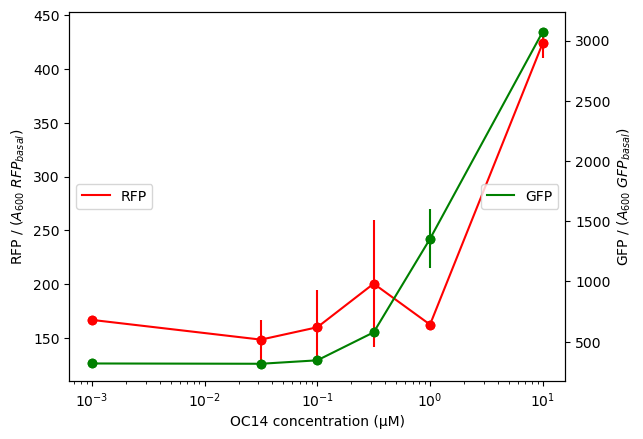

0.001000     1.007759
0.031623     1.000000
0.100000     1.090519
0.316228     1.825179
1.000000     4.279349
10.000000    9.715233
dtype: float64

In [10]:
OC14_list = [10**-3, 10**-1.5, 10**-1, 10**-0.5, 10**0, 10**1]
gfpReplicates = pd.DataFrame()
rfpReplicates = pd.DataFrame()


def IndexConcDict(ATC_layoutName,morphogen_layoutName,referenceDf):

    #get names of layouts
    ATC_layoutDict = layoutToDict(ATC_layoutName,referenceDf)
    morphogen_layoutDict = layoutToDict(morphogen_layoutName,referenceDf)
    # print(morphogen_layoutDict)
    #storage arrays
    ATC_layout_index = []
    highATC_morphogen_layoutDict = {}

    #loop over df of fixed molecule and select desired concentration
    for k,v in ATC_layoutDict.items():
        if v == '-0.5': #dose responses will be fixed for this concentration (e.g High ATC)
            ATC_layout_index.append(k)
    #loop over variable molecule #e.g OC14 or HSL
    for k,v in morphogen_layoutDict.items():
        if k in ATC_layout_index:
            if v == 'ZERO':
                highATC_morphogen_layoutDict[k] = -5
            else:
                highATC_morphogen_layoutDict[k] = v
    

    highATC_morphogen_layoutDict = dict(sorted(highATC_morphogen_layoutDict.items(), key=lambda item: float(item[1])))
    print(highATC_morphogen_layoutDict)
    return highATC_morphogen_layoutDict


for count, dataName in enumerate(data_list):
    print(dataName)
    #import data
    output_df = pd.read_excel(dataName)
    #take fluorescence for highest OD600
    od600Max, gfpMax, rfpMax, maxValueIndex = maxgrowth_data(output_df)
    #   # select only relevant index columns
    ATC_layoutName = ATC_layout_list[count]
    HSL_layoutName = HSL_layout_list[count]

    # print(ATC_layoutName, pC_layoutName)
    highATC_HSL_layoutDict = IndexConcDict(ATC_layoutName,HSL_layoutName,od600Max)

    # print(highATC_HSL_layoutDict)
    od600Max = od600Max[highATC_HSL_layoutDict.keys()]
    gfpMax = gfpMax[highATC_HSL_layoutDict.keys()]
    rfpMax = rfpMax[highATC_HSL_layoutDict.keys()]
    
    # subs_od600, subs_gfp, subs_rfp   = od600Max, gfpMax, rfpMax
    
    #relativise to od600
    relGfp = gfpMax/od600Max
    relRfp = rfpMax/od600Max

    print(relGfp, relRfp)
#     #Average intraexperimental replicates
    intraexperiment_mean_gfp = pd.Series(np.mean(np.stack((relGfp[:12:2], relGfp[1:13:2])), axis=0))
    intraexperiment_mean_rfp = pd.Series(np.mean(np.stack((relRfp[:12:2], relRfp[1:13:2])), axis=0))
    [1,3,]
    #add to dataframe
    gfpReplicates = gfpReplicates.append(intraexperiment_mean_gfp, ignore_index=True)
    rfpReplicates = rfpReplicates.append(intraexperiment_mean_rfp, ignore_index=True)


#define columns as OC14 concentrations
gfpReplicates.columns = OC14_list
rfpReplicates.columns = OC14_list
print(gfpReplicates)

#average interexperimental replicates 
meanGfp = gfpReplicates.mean(axis=0)
meanGfp_basal = meanGfp/np.amin(meanGfp)
stdGfp = gfpReplicates.std(axis=0)
stdGfp_basal = stdGfp/np.amin(meanGfp)

meanRfp = rfpReplicates.mean(axis=0)
meanRfp_basal = meanRfp/np.amin(meanRfp)
stdRfp = rfpReplicates.std(axis=0)
stdRfp_basal = stdRfp/np.amin(meanRfp)

plotDoseResponsevsData(OC14_list, meanRfp_basal, meanGfp_basal, stdRfp_basal ,stdGfp_basal, inducerName='OC14') 
plt.show()
plotDoseResponsevsData(OC14_list, meanRfp, meanGfp, stdRfp ,stdGfp, inducerName='OC14') 
meanGfp_basal


In [11]:
dataDict = {}
dataDict['OC14'] = OC14_list
dataDict['mean_gfp'] = meanGfp_basal
dataDict['std_gfp'] = stdGfp_basal
dataDict['mean_rfp'] = meanRfp_basal
dataDict['std_rfp'] = stdRfp_basal
pkl.dump(dataDict, open('curatedData/nonTransferred_subcircuit3_circuit14_doseResponseOC14_-0.5ATC.pkl', 'wb'))


In [8]:
OC14_list = [10**-3, 10**-1.5, 10**-1, 10**-0.5, 10**0, 10**1]
gfpReplicates = pd.DataFrame()
rfpReplicates = pd.DataFrame()


def IndexConcDict(ATC_layoutName,morphogen_layoutName,referenceDf):

    #get names of layouts
    ATC_layoutDict = layoutToDict(ATC_layoutName,referenceDf)
    morphogen_layoutDict = layoutToDict(morphogen_layoutName,referenceDf)
    # print(morphogen_layoutDict)
    #storage arrays
    ATC_layout_index = []
    highATC_morphogen_layoutDict = {}

    #loop over df of fixed molecule and select desired concentration
    for k,v in ATC_layoutDict.items():
        if v == '-0.5': #dose responses will be fixed for this concentration (e.g High ATC)
            ATC_layout_index.append(k)
    #loop over variable molecule #e.g OC14 or HSL
    for k,v in morphogen_layoutDict.items():
        if k in ATC_layout_index:
            if v == 'ZERO':
                highATC_morphogen_layoutDict[k] = -5
            else:
                highATC_morphogen_layoutDict[k] = v
    

    highATC_morphogen_layoutDict = dict(sorted(highATC_morphogen_layoutDict.items(), key=lambda item: float(item[1])))
    print(highATC_morphogen_layoutDict)
    return highATC_morphogen_layoutDict


for count, dataName in enumerate(data_list):
    print(dataName)
    #import data
    output_df = pd.read_excel(dataName)
    #take fluorescence for highest OD600
    od600Max, gfpMax, rfpMax, maxValueIndex = maxgrowth_data(output_df)
    #   # select only relevant index columns
    ATC_layoutName = ATC_layout_list[count]
    HSL_layoutName = HSL_layout_list[count]

    # print(ATC_layoutName, pC_layoutName)
    highATC_HSL_layoutDict = IndexConcDict(ATC_layoutName,HSL_layoutName,od600Max)

    # print(highATC_HSL_layoutDict)
    od600Max = od600Max[highATC_HSL_layoutDict.keys()]
    gfpMax = gfpMax[highATC_HSL_layoutDict.keys()]
    rfpMax = rfpMax[highATC_HSL_layoutDict.keys()]
    
    # subs_od600, subs_gfp, subs_rfp   = od600Max, gfpMax, rfpMax
    
    #relativise to od600
    relGfp = gfpMax/od600Max
    relRfp = rfpMax/od600Max

    print(relGfp, relRfp)
#     #Average intraexperimental replicates
    intraexperiment_mean_gfp = pd.Series(np.mean(np.stack((relGfp[:12:2], relGfp[1:13:2])), axis=0))
    intraexperiment_mean_rfp = pd.Series(np.mean(np.stack((relRfp[:12:2], relRfp[1:13:2])), axis=0))
    
    #add to dataframe
    gfpReplicates = gfpReplicates.append(intraexperiment_mean_gfp, ignore_index=True)
    rfpReplicates = rfpReplicates.append(intraexperiment_mean_rfp, ignore_index=True)


#define columns as OC14 concentrations
gfpReplicates.columns = OC14_list
rfpReplicates.columns = OC14_list
print(gfpReplicates)

#average interexperimental replicates 
meanGfp = gfpReplicates.mean(axis=0)
meanGfp_basal = meanGfp/np.amin(meanGfp)
stdGfp = gfpReplicates.std(axis=0)
stdGfp_basal = stdGfp/np.amin(meanGfp)

meanRfp = rfpReplicates.mean(axis=0)
meanRfp_basal = meanRfp/np.amin(meanRfp)
stdRfp = rfpReplicates.std(axis=0)
stdRfp_basal = stdRfp/np.amin(meanRfp)

plotDoseResponsevsData(OC14_list, meanRfp_basal, meanGfp_basal, stdRfp_basal ,stdGfp_basal, inducerName='OC14') 
plt.show()
plotDoseResponsevsData(OC14_list, meanRfp, meanGfp, stdRfp ,stdGfp, inducerName='OC14') 
meanGfp_basal


data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201214_120458.xlsx


NameError: name 'HSL_layout_list' is not defined

data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201214_120458.xlsx
{'B5': -5, 'B9': -5, 'C5': '-1.5', 'C9': '-1.5', 'D5': '-1', 'D9': '-1', 'E5': '-0.5', 'E9': '-0.5', 'F5': '0', 'F9': '0', 'G5': '1', 'G9': '1'}
B5     326.524741
B9     321.149377
C5     320.641283
C9     312.323745
D5     331.178161
D9     323.895028
E5     489.410418
E9     654.649619
F5     966.096825
F9    1393.660103
G5    2906.013427
G9    3202.016807
dtype: object B5    133.055236
B9    195.084161
C5     143.14343
C9    127.608573
D5    136.494253
D9    134.668508
E5    163.136806
E9    154.405086
F5    163.051286
F9    163.385002
G5    439.222968
G9    428.235294
dtype: object
data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201214_120458.xlsx
{'B5': -5, 'B9': -5, 'C5': '-1.5', 'C9': '-1.5', 'D5': '-1', 'D9': '-1', 'E5': '-0.5', 'E9': '-0.5', 'F5': '0', 'F9': '0', 'G5': '1', 'G9': '1'}
B5     326.524741
B9     321.149377
C5     320.641283
C9     312.323745
D5     331.178161
D9     323.895028
E5     489.410418
E9     654.6

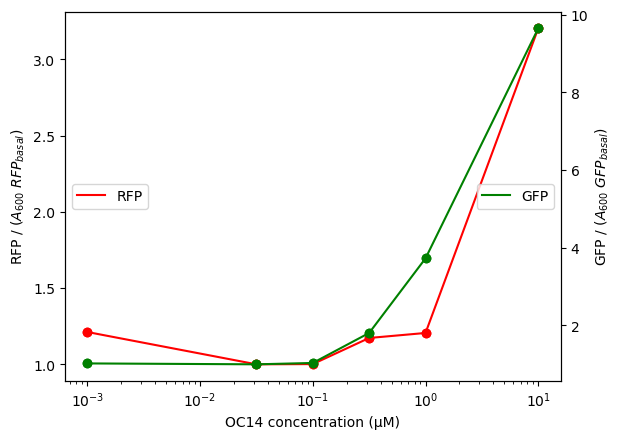

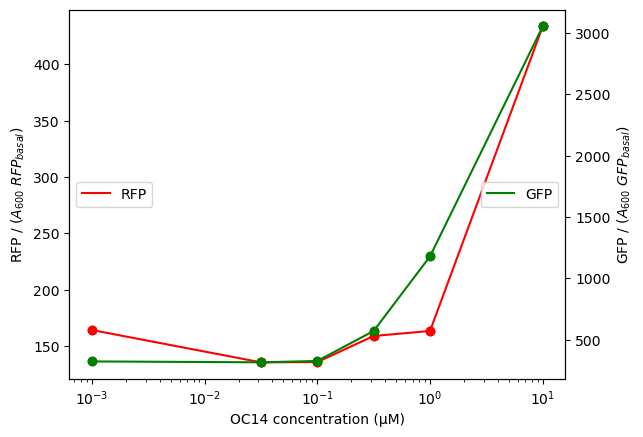

0.001000     1.023238
0.031623     1.000000
0.100000     1.034928
0.316228     1.807462
1.000000     3.728100
10.000000    9.649870
dtype: float64

In [134]:
OC14_list = [10**-3, 10**-1.5, 10**-1, 10**-0.5, 10**0, 10**1]
gfpReplicates = pd.DataFrame()
rfpReplicates = pd.DataFrame()


def IndexConcDict(ATC_layoutName,morphogen_layoutName,referenceDf):

    #get names of layouts
    ATC_layoutDict = layoutToDict(ATC_layoutName,referenceDf)
    morphogen_layoutDict = layoutToDict(morphogen_layoutName,referenceDf)
    # print(morphogen_layoutDict)
    #storage arrays
    ATC_layout_index = []
    highATC_morphogen_layoutDict = {}

    #loop over df of fixed molecule and select desired concentration
    for k,v in ATC_layoutDict.items():
        if v == '-0.5': #dose responses will be fixed for this concentration (e.g High ATC)
            ATC_layout_index.append(k)
    #loop over variable molecule #e.g OC14 or HSL
    for k,v in morphogen_layoutDict.items():
        if k in ATC_layout_index:
            if v == 'ZERO':
                highATC_morphogen_layoutDict[k] = -5
            else:
                highATC_morphogen_layoutDict[k] = v
    

    highATC_morphogen_layoutDict = dict(sorted(highATC_morphogen_layoutDict.items(), key=lambda item: float(item[1])))
    print(highATC_morphogen_layoutDict)
    return highATC_morphogen_layoutDict


for count, dataName in enumerate(data_list):
    print(dataName)
    #import data
    output_df = pd.read_excel(dataName)
    #take fluorescence for highest OD600
    od600Max, gfpMax, rfpMax, maxValueIndex = maxgrowth_data(output_df)
    #   # select only relevant index columns
    ATC_layoutName = ATC_layout_list[count]
    HSL_layoutName = HSL_layout_list[count]

    # print(ATC_layoutName, pC_layoutName)
    highATC_HSL_layoutDict = IndexConcDict(ATC_layoutName,HSL_layoutName,od600Max)

    # print(highATC_HSL_layoutDict)
    od600Max = od600Max[highATC_HSL_layoutDict.keys()]
    gfpMax = gfpMax[highATC_HSL_layoutDict.keys()]
    rfpMax = rfpMax[highATC_HSL_layoutDict.keys()]
    
    # subs_od600, subs_gfp, subs_rfp   = od600Max, gfpMax, rfpMax
    
    #relativise to od600
    relGfp = gfpMax/od600Max
    relRfp = rfpMax/od600Max

    print(relGfp, relRfp)
#     #Average intraexperimental replicates
    intraexperiment_mean_gfp = pd.Series(np.mean(np.stack((relGfp[:12:2], relGfp[1:13:2])), axis=0))
    intraexperiment_mean_rfp = pd.Series(np.mean(np.stack((relRfp[:12:2], relRfp[1:13:2])), axis=0))
    
    #add to dataframe
    gfpReplicates = gfpReplicates.append(intraexperiment_mean_gfp, ignore_index=True)
    rfpReplicates = rfpReplicates.append(intraexperiment_mean_rfp, ignore_index=True)


#define columns as OC14 concentrations
gfpReplicates.columns = OC14_list
rfpReplicates.columns = OC14_list
print(gfpReplicates)

#average interexperimental replicates 
meanGfp = gfpReplicates.mean(axis=0)
meanGfp_basal = meanGfp/np.amin(meanGfp)
stdGfp = gfpReplicates.std(axis=0)
stdGfp_basal = stdGfp/np.amin(meanGfp)

meanRfp = rfpReplicates.mean(axis=0)
meanRfp_basal = meanRfp/np.amin(meanRfp)
stdRfp = rfpReplicates.std(axis=0)
stdRfp_basal = stdRfp/np.amin(meanRfp)

plotDoseResponsevsData(OC14_list, meanRfp_basal, meanGfp_basal, stdRfp_basal ,stdGfp_basal, inducerName='OC14') 
plt.show()
plotDoseResponsevsData(OC14_list, meanRfp, meanGfp, stdRfp ,stdGfp, inducerName='OC14') 
meanGfp_basal
